In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from tensorflow.keras.layers import BatchNormalization


In [2]:
# ========== STEP 1: Load and Label Data ==========
def load_and_label_data(filepath, label):
    df = pd.read_csv(filepath)
    df['label'] = label
    return df

dataframes = [
    load_and_label_data("dataset/preprocessed_spam.csv", "spam"),
    load_and_label_data("dataset/preprocessed_promotions.csv", "promotions"),
    load_and_label_data("dataset/preprocessed_updates.csv", "updates"),
    load_and_label_data("dataset/preprocessed_social.csv", "social"),
]

df = pd.concat(dataframes, ignore_index=True)

In [5]:
# ========== STEP 2: Preprocessing ==========
def clean_text(text):
    text = text.lower()
    tokens = text.split()
    lemmatizer = WordNetLemmatizer()
    cleaned = [lemmatizer.lemmatize(w) for w in tokens if w not in stopwords.words('english')]
    return " ".join(cleaned)

df['text'] = df['Subject'].astype(str) + " " + df['Body'].astype(str)
df['text'] = df['text'].apply(clean_text)

# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
y = to_categorical(df['label_encoded'])

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(sequences, maxlen=200)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [75]:
# ========== STEP 3: Build CNN + BiLSTM Model ==========
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(64)))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(4, activation='softmax'))

# Compile
adam_optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

C:\Users\udgir\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [77]:
# ========== STEP 4: Training ==========
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
checkpoint = ModelCheckpoint('superImprovedDL.keras', monitor='val_loss', save_best_only=True)

model.fit(
    X_train, y_train,
    epochs=80,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/80
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.3916 - loss: 2.1388 - val_accuracy: 0.5908 - val_loss: 2.1516
Epoch 2/80
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - accuracy: 0.6928 - loss: 1.6670 - val_accuracy: 0.7080 - val_loss: 1.9936
Epoch 3/80
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.8274 - loss: 1.2867 - val_accuracy: 0.6061 - val_loss: 1.8438
Epoch 4/80
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.9122 - loss: 1.0052 - val_accuracy: 0.5076 - val_loss: 1.6848
Epoch 5/80
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.9549 - loss: 0.8295 - val_accuracy: 0.5823 - val_loss: 1.5400
Epoch 6/80
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - accuracy: 0.9682 - loss: 0.7436 - val_accuracy: 0.6740 - val_loss: 1.3912
Epoch 7/80
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.9760 - loss: 0.6616 - val_accuracy: 0.7963 - val_loss: 1.0883
Epoch 8/80
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.9774 - loss: 0.6144 - val_accuracy: 0.7284 -

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9271 - loss: 0.3572
Test Accuracy: 0.95
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step

Classification Report:
              precision    recall  f1-score   support

  promotions       0.92      0.92      0.92       401
      social       1.00      0.97      0.98       398
        spam       0.97      0.98      0.98       282
     updates       0.91      0.92      0.92       392

    accuracy                           0.95      1473
   macro avg       0.95      0.95      0.95      1473
weighted avg       0.95      0.95      0.95      1473

Accuracy Score: 0.9470
Macro F1 Score: 0.9492
Weighted F1 Score: 0.9472


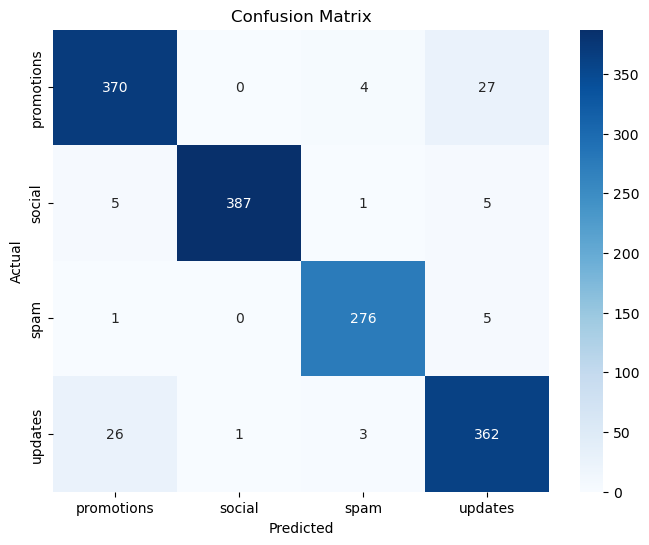


Detailed Classification Report:
              precision    recall  f1-score      support
promotions     0.920398  0.922693  0.921544   401.000000
social         0.997423  0.972362  0.984733   398.000000
spam           0.971831  0.978723  0.975265   282.000000
updates        0.907268  0.923469  0.915297   392.000000
accuracy       0.947047  0.947047  0.947047     0.947047
macro avg      0.949230  0.949312  0.949210  1473.000000
weighted avg   0.947562  0.947047  0.947240  1473.000000


In [79]:
# ========== STEP 5: Evaluation ==========
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))
print(f"Accuracy Score: {accuracy_score(y_true_classes, y_pred_classes):.4f}")
print(f"Macro F1 Score: {f1_score(y_true_classes, y_pred_classes, average='macro'):.4f}")
print(f"Weighted F1 Score: {f1_score(y_true_classes, y_pred_classes, average='weighted'):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report (already printed)
report = classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print("\nDetailed Classification Report:")
print(report_df)

# Save report to CSV (optional)
report_df.to_csv("detailed_classification_report.csv", index=True)
